# Computational Carpentry - Project
#### Group K - Julian Barth, Marin Desgeans, Lucas Eichenberger
26 september 2025


#### Part A – Data structures and functions

The goal of this part is to create a function capable of calculating the molecular mass of any molecule. For this we will first load a periodic table containing all the elements' masses.

In [2]:
import pandas as pd
import re
from collections import defaultdict

# 1. Load periodic_table.csv
df = pd.read_csv("periodic_table.csv")

We are now able to create a dictionnary where the keys are elements symbol and the values are atomic 
masses. We have shown the first 5 elements.

In [3]:
# 2. Create dictionary
atomic_masses = dict(zip(df["Symbol"], df["AtomicMass"]))

print(dict(list(atomic_masses.items())[:5]))

{'H': 1.008, 'He': 4.0026, 'Li': 7.0, 'Be': 9.012183, 'B': 10.81}


We can now write a simple function that calculates the molecular mass of a molecule. The pattern will recognise the element and capture the following number that represents the number of atom of this element in the molecule. A simple loop will then calculate the molecular mass of the molecule and return it. 

You may run the cell to verify the good usage of the function. 

In [4]:
# 3. Create function to compute molecular mass
def molecular_mass(formula: str) -> float:
    """
    Compute molecular mass of a formula like 'H2O' or 'C6H12O6'
    """
    pattern = r"([A-Z][a-z]?)(\d*)" 
    #([A-Z][a-z]?) is an element symbol (1 uppercase, optional lowercase)
    # (\d*) is an optional number (the count of atoms)
    mass = 0.0
    for element, count in re.findall(pattern, formula):
        count = int(count) if count else 1 # If no number after element (e.g. 'O'), assume count = 1
        mass += atomic_masses[element] * count # Add contribution of this element to the total mass
    return mass

# Example usage
print(molecular_mass("H2O"))  #18.015 g/mol
print(molecular_mass("C6H12O6"))  #180.156 g/mol
print(molecular_mass("NaCl"))  #58.44 g/mol

18.015
180.156
58.4397693


We now want to upgrade the function in order for it to handle parentheses in formulas.

In [6]:
def parse_formula_recursive(tokens, i=0):
    """
    Recursive parser for formulas with parentheses.
    Input:
        tokens - list of symbols, parentheses, and numbers
        i      - current position in the token list
    Output:
        (counts, i) where counts is a dict of element counts,
        and i is the next index to continue parsing from.
    """
    counts = defaultdict(int)  # store element counts for this level

    while i < len(tokens):
        token = tokens[i]

        if token == "(":
            # Found an opening parenthesis → recurse to parse inside
            sub_counts, i = parse_formula_recursive(tokens, i + 1)

            # After returning, check if a multiplier follows the ")"
            multiplier = 1
            if i < len(tokens) and tokens[i].isdigit():
                multiplier = int(tokens[i])
                i += 1

            # Add multiplied sub_counts to the current level
            for elem, cnt in sub_counts.items():
                counts[elem] += cnt * multiplier

        elif token == ")":
            # Found a closing parenthesis → return current group
            return counts, i + 1

        elif re.match(r"[A-Z][a-z]?", token):
            # Found an element symbol (e.g. H, He, O)
            elem = token
            i += 1

            # Check if the element has a count (like H2)
            count = 1
            if i < len(tokens) and tokens[i].isdigit():
                count = int(tokens[i])
                i += 1

            counts[elem] += count  # add element count to current group
            continue

        else:
            # Skip anything unexpected (defensive coding)
            i += 1

    # End of formula (top-level return)
    return counts, i


def molecular_mass_parentheses(formula: str) -> float:
    """
    Compute molecular mass of a formula with parentheses using recursion.
    """
    # Tokenize the formula into symbols, parentheses, and numbers
    tokens = re.findall(r"([A-Z][a-z]?|\(|\)|\d+)", formula)

    # Parse recursively starting at index 0
    elements, _ = parse_formula_recursive(tokens)

    # Compute total mass by summing atomic mass * count
    return sum(atomic_masses[e] * n for e, n in elements.items())

# Example usage
print(molecular_mass_parentheses("Ca(OH)2"))  #74.094 g/mol

74.09400000000001


Let us extend the molecular mass calculator so it can handle coordinated (hydration) water, as would be the case in CuSO4·5H2O.

In [24]:
# 5. Handle hydration water "·"

def molecular_mass_hydrate(formula: str) -> float:
    """
    Calculate the molar mass of a compound, including hydrates using dot notation.
    
    Example:
        "CuSO4·5H2O" -> copper(II) sulfate pentahydrate
        
    Parameters:
        formula (str): Chemical formula, can include a hydrate part (e.g., '·5H2O')
    
    Returns:
        float: Total molar mass in g/mol
    """
    # Split the formula on the dot (·) which separates the main compound from the water molecules
    parts = formula.split("·")
    total_mass = 0  # Initialize total molar mass
    
    for part in parts:
        # Check if the part starts with a number (e.g., '5H2O')
        match = re.match(r"(\d+)([A-Za-z].*)", part)
        if match:
            multiplier = int(match.group(1))  # e.g., 5
            subformula = match.group(2)       # e.g., H2O
            # Multiply the molar mass of the subformula by the multiplier
            total_mass += multiplier * molecular_mass_parentheses(subformula)
        else:
            # No leading number: just add the mass of the formula directly
            total_mass += molecular_mass_parentheses(part)
    
    return total_mass

# Example usage
print(molecular_mass_hydrate("CuSO4·5H2O"))  # Should print ~249.691 g/mol

249.69100000000003


### Part B - Stoichiometry and reaction balancing

In this part, we will focus on balancing chemical equations. 

The goal is to write a function that takes as input a list of chemical formulas for reactants products. It should return a list of stoichiometric coefficients that balance the reaction.

As a first step, a utility `function element_count(formula)` is used to count the number of each element in a formula.

In [44]:
import numpy as np
from sympy import Matrix

# Utility: element counts for formulas
def element_count(formula: str) -> dict:
    pattern = r"([A-Z][a-z]?)(\d*)"
    counts = defaultdict(int)
    for element, num in re.findall(pattern, formula):
        counts[element] += int(num) if num else 1
    return dict(counts)

# Test cases for element_count
test_formulas = ["H2O", "CO2"]

for formula in test_formulas:
    counts = element_count(formula)
    print(f"Formula: {formula} -> Element counts: {counts}")

Formula: H2O -> Element counts: {'H': 2, 'O': 1}
Formula: CO2 -> Element counts: {'C': 1, 'O': 2}


With this, the `balance_reaction` function finds stoichiometric coefficients that balance a chemical reaction. It combines reactants and products and identifies all elements. It builds a matrix where each row is an element and each column is a species, with reactants positive and products negative. The matrix nullspace gives a solution for the coefficients. Fractions are converted to integers using the least common multiple. The function returns the coefficients in order of reactants and products.

In [45]:
# 1. Balance reaction
def balance_reaction(reactants, products):
    # Combine all species for processing
    species = reactants + products
    
    # Collect all unique elements in the reaction
    elements = set()
    for f in species:
        elements |= set(element_count(f).keys())
    elements = list(elements)

    # Build the matrix representing the system of equations
    # Each row corresponds to an element
    # Each column corresponds to a species
    # Reactants are positive, products are negative
    A = []
    for elem in elements:
        row = []
        for f in reactants:
            row.append(element_count(f).get(elem, 0))
        for f in products:
            row.append(-element_count(f).get(elem, 0))
        A.append(row)

    # Convert the list of lists into a sympy Matrix
    M = Matrix(A)
    
    # Solve for the nullspace, which gives the coefficients
    nullspace = M.nullspace()
    if not nullspace:
        raise ValueError("No solution found")
    
    # Take the first vector from the nullspace as the solution
    coeffs = nullspace[0]
    
    # Convert fractional coefficients to integers
    lcm = np.lcm.reduce([c.q for c in coeffs])  # find least common multiple of denominators
    coeffs = [int(c*lcm) for c in coeffs]
    
    return coeffs

# Example tests
print(balance_reaction(["H2","O2"], ["H2O"]))         # 2H2 + O2 → 2H2O
print(balance_reaction(["C2H6","O2"], ["CO2","H2O"])) # 2C2H6 + 7O2 → 4CO2 + 6H2O
print(balance_reaction(["Fe","O2"], ["Fe2O3"]))       # 4Fe + 3O2 → 2Fe2O3

[2, 1, 2]
[2, 7, 4, 6]
[4, 3, 2]


To be practical, let's modify the code to make it fully safeproof. In particular, what if the user didn't input things right? or worse, if there are no solutions? 

In [46]:
# 1. Balance reaction
def balance_reaction(reactants, products):
    # Safeguard: ensure there is at least one reactant and one product
    if not reactants or not products:
        raise ValueError("Reaction must have at least one reactant and one product")
    
    # Safeguard: check that all formulas are non-empty strings
    for f in reactants + products:
        if not isinstance(f, str) or not f.strip():
            raise ValueError(f"Invalid chemical formula: '{f}'")
    
    species = reactants + products
    elements = set()
    for f in species:
        elements |= set(element_count(f).keys())
    elements = list(elements)

    A = []
    for elem in elements:
        row = []
        for f in reactants:
            row.append(element_count(f).get(elem, 0))
        for f in products:
            row.append(-element_count(f).get(elem, 0))
        A.append(row)

    M = Matrix(A)
    
    # Safeguard: check that nullspace exists and is not all zeros
    nullspace = M.nullspace()
    if not nullspace or all(c == 0 for c in nullspace[0]):
        raise ValueError("No valid solution found for the reaction")
    
    # 1. No reactants (same for products)
try:
    balance_reaction([], ["H2O"])
except ValueError as e:
    print(e)  # Output: Reaction must have at least one reactant and one product

# 2. Invalid formula (non-string)
try:
    balance_reaction(["H2", 123], ["H2O"])
except ValueError as e:
    print(e)  # Output: Invalid chemical formula: '123'

# 3. Reaction that cannot be balanced (e.g., impossible reaction)
try:
    balance_reaction(["H2"], ["CO2"])
except ValueError as e:
    print(e)  # Output: No valid solution found for the reaction

Reaction must have at least one reactant and one product
Invalid chemical formula: '123'
No valid solution found for the reaction


Now, we can also check wether the total mass of the reactants is conserved in the products, as would be the case accoring to the Lavoisier principle. We have used the `molecular_mass_parentheses` established before

In [50]:
# 2. Mass conservation check
def check_mass_conservation(reactants, products, coeffs):
    n_reactants = len(reactants)
    
    # Calculate total mass of reactants using their coefficients
    react_mass = sum(molecular_mass_parentheses(f)*coeffs[i] for i,f in enumerate(reactants))

    # Calculate total mass of products using their coefficients
    prod_mass  = sum(molecular_mass_parentheses(f)*coeffs[i+n_reactants] for i,f in enumerate(products))
    return abs(react_mass - prod_mass) < 1e-6

# Example usage
print(check_mass_conservation(["H2","O2"], ["H2O"], [2,1,2]))  # True
print(check_mass_conservation(["C2H6","O2"], ["CO2","H2O"], [2,7,4,6])) # True
print(check_mass_conservation(["Fe","O2"], ["Fe2O3"], [4,3,2]))  # True

print(check_mass_conservation(["H2","O2"], ["H2O"], [2,1,1]))  # False


True
True
True
False


### Part C - Simulation / Modeling

The goal of this exercise is to estimate the value of π using a Monte Carlo simulation. The method is based on randomly generating points in a square and counting how many fall inside a circle. The ratio of points inside the circle to the total points is proportional to the area of the circle, which allows us to estimate π. As the number of points increases, the estimate converges to the actual value of π.

Consider a square with side length 2 centered at the origin. Its area is:

$𝐴_{square}=2⋅2=4$

Inside this square, consider a circle of radius 1. Its area is:

$𝐴{circle}=𝜋𝑟^2=𝜋⋅1^2=𝜋$

The probability that a random point inside the square also lies inside the circle is:

$P(point in circle)=\frac{A_{circle}}{A_{sqaure}​}= \frac{π}{4}$

If we generate 𝑁 random points and count $𝑁_{inside}$ points that fall inside the circle, the fraction inside the circle approximates this probability:

$\frac{N_{inside}}{N}≈\frac{pi}{4}$



3.1612


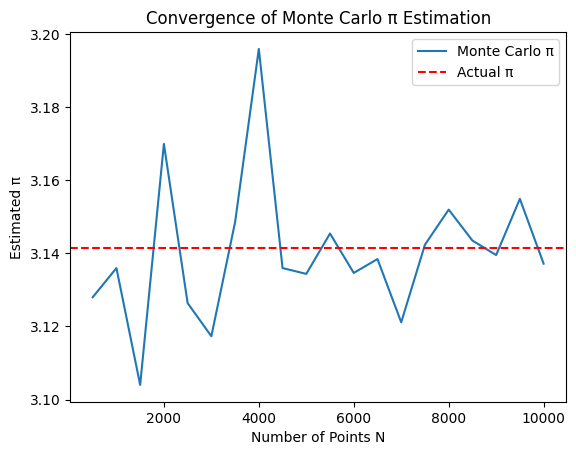

In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np  # Needed for the actual π line in the plot

# Function to estimate π using N random points
def estimate_pi(N):
    inside = 0  # Counter for points that fall inside the unit circle
    for _ in range(N):
        # Generate a random point (x, y) in the square from -1 to 1
        x, y = random.uniform(-1,1), random.uniform(-1,1)
        # Check if the point is inside the unit circle (distance from origin ≤ 1)
        if x**2 + y**2 <= 1:
            inside += 1
    # Estimate π as 4 times the fraction of points inside the circle
    return 4 * inside / N

# Function to visualize how the π estimate converges as N increases
def convergence_plot(maxN=10000, step=500):
    estimates = []
    # Calculate π estimates at intervals of 'step' up to 'maxN'
    trials = range(step, maxN+1, step)
    for n in trials:
        estimates.append(estimate_pi(n))
    # Plot the Monte Carlo estimates
    plt.plot(trials, estimates, label="Monte Carlo π")
    # Add a reference line showing the actual value of π
    plt.axhline(np.pi, color="r", linestyle="--", label="Actual π")
    plt.xlabel("Number of Points N")
    plt.ylabel("Estimated π")
    plt.title("Convergence of Monte Carlo π Estimation")
    plt.legend()
    plt.show()

# Example usage
print(estimate_pi(10000))          # Estimate π using 10,000 points
convergence_plot(10000, 500)      # Visualize convergence of the estimate

Monte Carlo can also be used in chemistry. For example, it cand model molecular collisions in a box and estimate the probability that a collision has enough energy to overcome a reaction threshold. 

1) Each collision is assigned a random energy, which can be drawn either from a uniform distribution or a Gaussian (normal) distribution. 
2) By generating a large number of collisions, we can use the fraction of collisions that exceed a specified energy threshold as an estimate of the reaction probability. This approach is inspired by kinetic theory in chemistry, where molecules in a gas have a distribution of energies, and only those with sufficient energy can participate in reactions. 

The Monte Carlo method is well suited for this task because it relies on repeated random sampling to estimate a quantity that would be difficult to calculate exactly. The output of the simulation includes both the estimated probability and the list of energies for all collisions, which can be used to analyze the energy distribution or visualize it with a histogram.

Estimated reaction probability (uniform): 0.4976
Estimated reaction probability (Gaussian): 0.5028


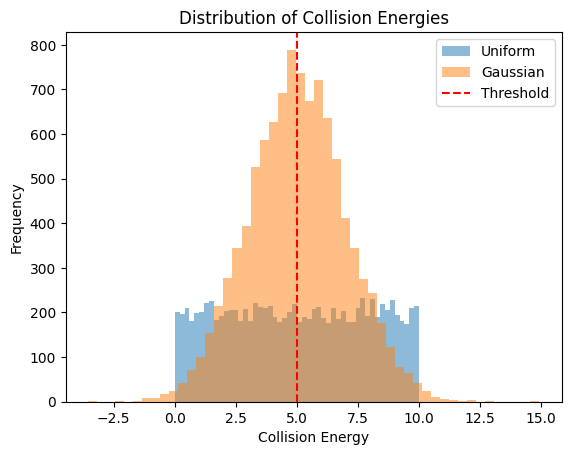

In [62]:
# 2. Chemistry-inspired Monte Carlo
def simulate_collisions(M, threshold=5.0, distribution="uniform"):
    exceed = 0        # Counter for collisions exceeding threshold energy
    energies = []     # List to store the energy of each collision
    for _ in range(M):
        if distribution == "uniform":
            e = random.uniform(0, 10)  # Random energy between 0 and 10
        else:
            e = random.gauss(5, 2)     # Random energy from Gaussian distribution
        energies.append(e)
        if e > threshold:
            exceed += 1
    # Return estimated reaction probability and list of energies
    return exceed / M, energies

# Example usage
prob_uniform, energies_uniform = simulate_collisions(10000, distribution="uniform")  # Probability with uniform distribution
prob_gauss, energies_gauss = simulate_collisions(10000, distribution="gauss")      # Probability with Gaussian distribution

# Print the estimated probabilities
print(f"Estimated reaction probability (uniform): {prob_uniform:.4f}")
print(f"Estimated reaction probability (Gaussian): {prob_gauss:.4f}")

# Plot histograms of collision energies for visualization
plt.hist(energies_uniform, bins=50, alpha=0.5, label="Uniform")
plt.hist(energies_gauss, bins=50, alpha=0.5, label="Gaussian")
plt.axvline(5.0, color="r", linestyle="--", label="Threshold")
plt.xlabel("Collision Energy")
plt.ylabel("Frequency")
plt.title("Distribution of Collision Energies")
plt.legend()
plt.show()

*Note to reader*:
In this project, ChatGPT (GPT-5, by OpenAI) was used as a supplementary resource. It was consulted to look up Python functions, to obtain example usages, and to clarify implementation details. The provided information was adapted and integrated into the final work.